## Installing packages

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install huggingface-hub

In [ ]:
!pip install matplotlib

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip3 install umap-learn

In [ ]:
!pip3 install scikit-learn

## Code

In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")

c:\Users\vloba\git\Transformers\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoTokenizer

model_ckpt="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)


In [4]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [5]:
emotions_encoded=emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded["train"].column_names

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map: 100%|██████████| 2000/2000 [00:00<00:00, 14489.60 examples/s]


['text', 'label', 'input_ids', 'attention_mask']

In [6]:
import torch
from transformers import AutoModel

device="cuda" if torch.cuda.is_available() else "cpu"
model=AutoModel.from_pretrained(model_ckpt).to(device)
device

'cuda'

In [7]:
def extract_hidden_states(batch):
    inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state=model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [8]:
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden=emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map: 100%|██████████| 2000/2000 [00:00<00:00, 2765.63 examples/s]


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [9]:
import numpy as np

X_train=np.array(emotions_hidden["train"]["hidden_state"])
y_train=np.array(emotions_hidden["train"]["label"])
X_valid=np.array(emotions_hidden["validation"]["hidden_state"])
y_valid=np.array(emotions_hidden["validation"]["label"])

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((16000, 768), (16000,), (2000, 768), (2000,))

In [11]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

X_scaled=MinMaxScaler().fit_transform(X_train)
mapper=UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb=pd.DataFrame(mapper.embedding_, columns=["X", "y"])
df_emb["label"]=y_train
df_emb.head()

,X,y,label
0,4.240474,6.184024,0
1,-2.848679,6.044124,0
2,5.127984,2.772398,3
3,-2.453121,3.856505,2
4,-3.325711,4.186810,3


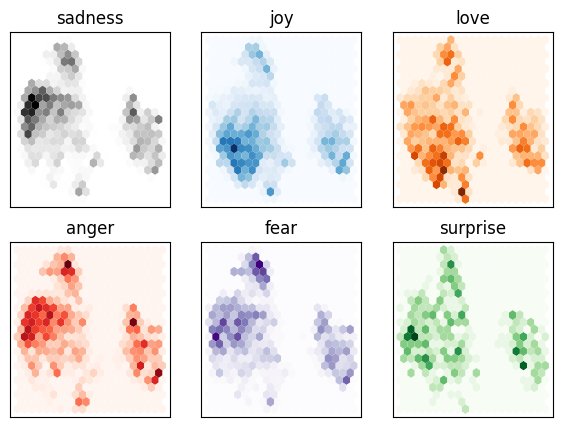

In [14]:
import matplotlib.pyplot as plt

fig, axes=plt.subplots(2,3,figsize=(7,5))
axes=axes.flatten()
cmaps=["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels=emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub=df_emb.query(f"label=={i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [15]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)



0.633

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf=DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

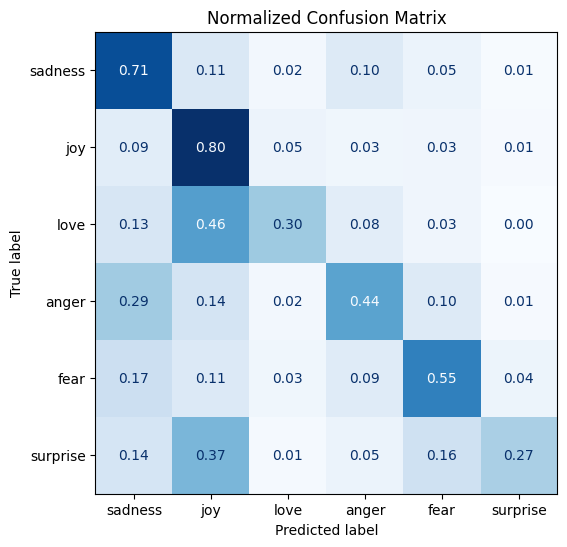

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm=confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

y_preds=lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## My Work - Classifier

In [5]:
from datasets import load_dataset

emotions=load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row["label"])

df=emotions["train"].to_pandas()
df["names"]=df.apply(label_int2str, axis=1)
df.head()



,text,label,names
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Text(0.5, 1.0, 'Emotion Distribution')

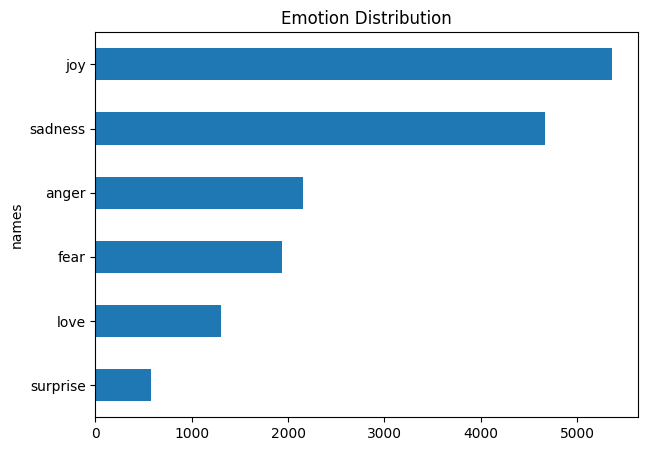

In [18]:
df["names"].value_counts(ascending=True).plot(kind="barh", figsize=(7,5))
plt.title("Emotion Distribution")

In [19]:
from transformers import AutoTokenizer

model_ckpt="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

In [24]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded=emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [22]:
import torch

device="cuda" if torch.cuda.is_available() else "cpu"

In [23]:
from transformers import AutoModel

model=AutoModel.from_pretrained(model_ckpt).to(device)

In [25]:
def extract_hidden_states(batch):
    inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state=model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden=emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map: 100%|██████████| 2000/2000 [00:00<00:00, 2852.39 examples/s]


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [26]:
from sklearn.linear_model import LogisticRegression

X_train=np.array(emotions_hidden["train"]["hidden_state"])
y_train=np.array(emotions_hidden["train"]["label"])
X_valid=np.array(emotions_hidden["validation"]["hidden_state"])
y_valid=np.array(emotions_hidden["validation"]["label"])


0.633

In [40]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled=MinMaxScaler().fit_transform(X_train)
mapper=UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb=pd.DataFrame(mapper.embedding_, columns=["X", "y"])
df_emb["label"]=emotions_encoded["train"]["label"]
df_emb.head()

,X,y,label
0,4.353909,6.356849,0
1,-3.033778,5.512530,0
2,5.247719,2.887991,3
3,-2.396722,3.378384,2
4,-3.367889,3.544937,3


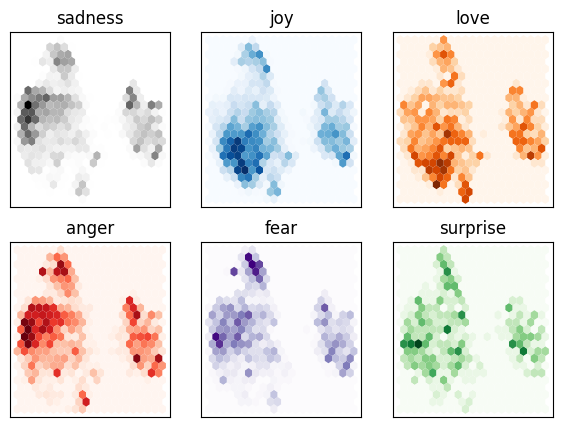

In [41]:
fig, axes=plt.subplots(2,3,figsize=(7,5))
axes=axes.flatten()
cmaps=["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels=emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub=df_emb.query(f"label=={i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [42]:

lr_clf=LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [27]:
from sklearn.dummy import DummyClassifier

dummy_clf=DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

## Fine-tunning Transformers

In [1]:
from transformers import AutoModelForSequenceClassification
import torch

model_ckpt="distilbert-base-uncased"
device="cuda" if torch.cuda.is_available() else "cpu"
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6).to(device)

c:\Users\vloba\git\Transformers\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
from transformers import AutoTokenizer

tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [3]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)
    acc=accuracy_score(labels, preds)
    f1=f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [4]:
from transformers import TrainingArguments, Trainer
from datasets import load_dataset

emotions=load_dataset("emotion")
emotions_encoded=emotions.map(tokenize, batched=True, batch_size=None)
batch_size=64
logging_steps=len(emotions["train"])//batch_size
model_name=f"{model_ckpt}-finetuned-emotions"
args=TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    logging_steps=logging_steps,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=False,
    load_best_model_at_end=True,
    log_level="error",
    metric_for_best_model="accuracy",
    greater_is_better=True,
    seed=42
)


In [5]:
trainer = Trainer(
    model,
    args,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
    

 33%|███▎      | 250/750 [00:22<00:41, 12.02it/s]

{'loss': 0.5344, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


                                                 
 33%|███▎      | 250/750 [00:23<00:41, 12.02it/s]

{'eval_loss': 0.19680723547935486, 'eval_accuracy': 0.9305, 'eval_f1': 0.9307655993245479, 'eval_runtime': 0.8742, 'eval_samples_per_second': 2287.886, 'eval_steps_per_second': 36.606, 'epoch': 1.0}


 67%|██████▋   | 500/750 [00:45<00:20, 12.04it/s]

{'loss': 0.144, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 500/750 [00:46<00:20, 12.04it/s]

{'eval_loss': 0.13764673471450806, 'eval_accuracy': 0.9375, 'eval_f1': 0.9376492803268187, 'eval_runtime': 0.875, 'eval_samples_per_second': 2285.8, 'eval_steps_per_second': 36.573, 'epoch': 2.0}


100%|██████████| 750/750 [01:08<00:00, 11.90it/s]

{'loss': 0.0934, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 750/750 [01:09<00:00, 11.90it/s]

{'eval_loss': 0.1395956575870514, 'eval_accuracy': 0.939, 'eval_f1': 0.9390424651362298, 'eval_runtime': 0.8818, 'eval_samples_per_second': 2268.208, 'eval_steps_per_second': 36.291, 'epoch': 3.0}


100%|██████████| 750/750 [01:11<00:00, 10.53it/s]

{'train_runtime': 71.2199, 'train_samples_per_second': 673.969, 'train_steps_per_second': 10.531, 'train_loss': 0.25726795705159505, 'epoch': 3.0}


TrainOutput(global_step=750, training_loss=0.25726795705159505, metrics={'train_runtime': 71.2199, 'train_samples_per_second': 673.969, 'train_steps_per_second': 10.531, 'train_loss': 0.25726795705159505, 'epoch': 3.0})

In [6]:
pred_outputs=trainer.predict(emotions_encoded["validation"])
pred_outputs.metrics

100%|██████████| 32/32 [00:00<00:00, 38.55it/s]


{'test_loss': 0.1395956575870514,
 'test_accuracy': 0.939,
 'test_f1': 0.9390424651362298,
 'test_runtime': 1.1123,
 'test_samples_per_second': 1798.135,
 'test_steps_per_second': 28.77}

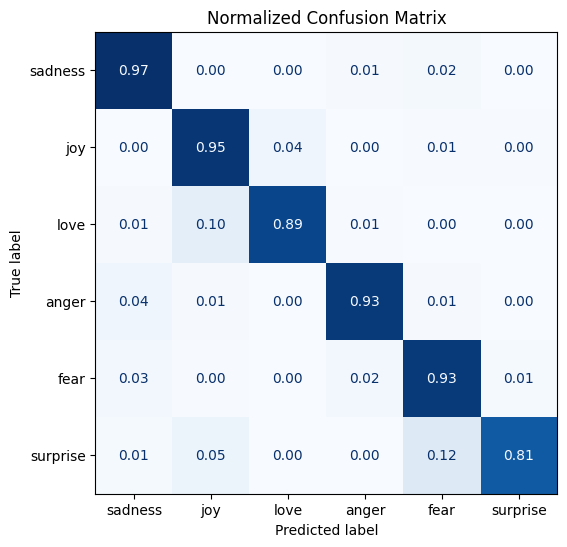

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm=confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

y_preds=pred_outputs.predictions.argmax(-1)
y_valid=emotions_encoded["validation"]["label"]
labels=emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [26]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        outputs=model(**inputs)
        pred_labels=torch.argmax(outputs.logits, axis=-1)
        loss=cross_entropy(outputs.logits, batch["label"].to(device), reduction="none")
    return {"loss": loss.cpu().numpy(), "pred_labels": pred_labels.cpu().numpy()}

In [28]:
emotions_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

emotions_encoded["validation"]=emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map: 100%|██████████| 2000/2000 [00:01<00:00, 1545.53 examples/s]


In [31]:
emotions_encoded.set_format("pandas")
cols=["text", "label", "pred_labels", "loss"]
df_test=emotions_encoded["validation"][:][cols]
df_test["label"]=df_test["label"].apply(lambda x: emotions["train"].features["label"].int2str(x))
df_test["pred_labels"]=df_test["pred_labels"].apply(lambda x: emotions["train"].features["label"].int2str(x))

In [32]:
df_test.sort_values(by="loss", ascending=False).head(10)

,text,label,pred_labels,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,7.497535
177,im sure much of the advantage is psychological...,sadness,joy,7.483234
1963,i called myself pro life and voted for perry w...,joy,sadness,6.325457
1500,i guess we would naturally feel a sense of lon...,anger,sadness,6.172555
882,i feel badly about reneging on my commitment t...,love,sadness,5.585982
415,im kind of embarrassed about feeling that way ...,love,joy,5.466532
1111,im lazy my characters fall into categories of ...,joy,fear,5.401127
1919,i should admit when consuming alcohol myself i...,fear,sadness,4.894072
1124,someone acting stupid in public,anger,sadness,4.757446
1836,i got a very nasty electrical shock when i was...,fear,anger,4.602091


In [34]:
df_test.sort_values(by="loss", ascending=True).head(10)

,text,label,pred_labels,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.001177
702,i only find out that they are looking and feel...,joy,joy,0.001235
107,i feel the cool edge of the barrel against my ...,joy,joy,0.001241
578,i got to christmas feeling positive about the ...,joy,joy,0.001244
1688,i feel very very rich and fulfilled and a part...,joy,joy,0.001245
1607,i feel incredibly mellow and spacey,joy,joy,0.001252
1728,i really feel entertained and informed when i ...,joy,joy,0.001253
1659,i feel as if is useful,joy,joy,0.001261
908,i said earlier that the overall feeling is joy...,joy,joy,0.001266
715,i feel mellow i feel free and i feel completel...,joy,joy,0.001267
